In [1]:
!pip install --user uproot
!pip install --user tqdm
!pip install awkward
!pip install xgboost
!pip install sklearn
!pip install seaborn

In [2]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import numpy as np
import awkward as ak
import ROOT
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/02


In [3]:
#root_files = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/CR_plot/BDT_train/output-slimmed-rootfiles/optimal*.root")
root_files = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*.root")


In [4]:
root_files[0]

'/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST16.root'

In [5]:
f1 = uproot.open(root_files[0])
tree=f1['outtree']

In [6]:
branch=tree.keys()
unneccesary_columns = ['LHEScaleWeight','LHEPdfWeight']
for c in unneccesary_columns:
    branch.remove(c)
len(branch)

115

In [7]:
c={}
for key in branch:
    c[key]=tree[key].array()

In [8]:
f = uproot.lazy(root_files[0]+':outtree')
events = ak.to_pandas(f[branch])
len(f)

72

In [9]:
import math
def get_df(root_file_name):        
    f = uproot.lazy(root_file_name+":outtree")
    if len(f) == 0:
        return pd.DataFrame()
    df = ak.to_pandas(f[branch])
    return df        

In [73]:
df = pd.concat((get_df(f) for f in tqdm(root_files)), ignore_index=True)

100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.87it/s]


In [74]:
df.shape

(18461, 115)

In [75]:
features=['lep1pt','lep1eta','lep1phi','lep2pt','lep2eta','lep2phi','drll','PuppiMET_T1Smear_pt','PuppiMET_T1Smear_phi','photonet','photoneta','photonphi','drl1a','drl2a']
#features=['lep1pt','lep2pt','lep1eta','lep2eta','lep1phi','lep2phi','drll','ptll','yVlep','phiVlep','mll','mT','mT2','PuppiMET_T1Smear_pt','PuppiMET_T1Smear_phi','photonet','photoneta','drl1a','drl2a','n_bjets20_medium']


In [76]:
#for feature in features:    
#    Bins=40
#    plt.figure()
#    a=df.query('isSignal==1 & njets30==0')
#    b=df.query('isSignal!=1 & njets30==0')
#    plt.hist(a[feature],bins=Bins,histtype="step",label="Signal_Test",density = True)
#    plt.hist(b[feature],bins=Bins,histtype="step",label="Signal_Test",density = True)
#    plt.xlabel(feature)

In [77]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
#import xgboost2tmva 

- hyperparamter tuning for XGboost

In [514]:
n_boost_rounds = 10
xgboost_params = {'eval_metric':'auc',
                  'max_depth' : 4,
                  'eta':0.15,
                  'objective'  :'binary:logistic'}

- Separate different categories according to the number of njets30

In [515]:
category=['0jets','1jets']

In [516]:
df.loc[df.query('actualWeight<0').index,'actualWeight']

425     -0.008261
431     -0.008523
436     -0.009723
437     -0.006875
439     -0.007774
           ...   
18453   -0.000116
18454   -0.000096
18455   -0.000104
18456   -0.000118
18458   -0.000098
Name: actualWeight, Length: 6032, dtype: float32

In [517]:
for i,group_df in df.groupby('njets30'):
#    print(i,'',group_df['njets30'])    

    group_df.loc[group_df.query('actualWeight<0').index,'actualWeight']=0
    
    X=group_df[features]
    Y=group_df['isSignal']
    
    #random_state is the seed used by the random number generator, 
    #random_state=42 make others get the same data spliting in different executions.
    # shuffle make the bkg and signal mix randomly.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, 
                                                        random_state=42,shuffle=True)
    idx_train = X_train.index
    idx_test = X_test.index
    
    # XGBoost has it's own data format, so we have to create these structures. 
    #(The copies have no specific purpose other than silencing an xgboost warning.)

    print(X_train.shape,group_df.loc[idx_train,'actualWeight'].shape)
    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train),weight=group_df.loc[idx_train,'actualWeight'])
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ),weight=group_df.loc[idx_test,'actualWeight'])

    
    n_pos = np.sum(group_df.loc[group_df.loc[idx_train].query('isSignal==1').index,'actualWeight'])
    n_neg = np.sum(group_df.loc[group_df.loc[idx_train].query('isSignal==0').index,'actualWeight'])
    
    print('number of bkg ',n_neg,' number of sig ',n_pos,' ,ratio ',n_neg/n_pos)
    print('number of bkg in test',np.sum(y_test == 0),' ,number of sig in test ',np.sum(y_test == 1), ' ,ratio ',np.sum(y_test == 0)/np.sum(y_test == 1))
    # There is one additional hyperparameter needed to set per catoegy: `scale_pos_weight`.
    # It corresponds  to a weight given to every positive sample, and it usually set to
    # n_neg / n_pos when you have imbalanced datasets to balance the total contributions
    # of the positive and negative classes in the loss function
    
    xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos
    
    # Train
    model = xgb.train(xgboost_params,
                      dmatrix_train,
                      num_boost_round=n_boost_rounds,
                      evals= [(dmatrix_train, 'train'),
                              (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    best_iteration = model.best_iteration + 1
    if best_iteration < n_boost_rounds:
        print("early stopping after {0} boosting rounds".format(best_iteration))
    print("")
    
    model.save_model("model_"+category[i]+'.json')
 
    # Add new column for the BDT output
    df.loc[idx_train, "score"] = model.predict(dmatrix_train)
    df.loc[idx_test, "score"] = model.predict(dmatrix_test)
    
    # Add new column to separate the test and train
    df.loc[idx_train, "test"] = False
    df.loc[idx_test, "test"] = True

(5985, 14) (5985,)
number of bkg  98.20479  number of sig  1.6214445  ,ratio  60.566235
number of bkg in test 918  ,number of sig in test  3072  ,ratio  0.298828125

(5091, 14) (5091,)
number of bkg  122.747635  number of sig  0.96977466  ,ratio  126.57336
number of bkg in test 1403  ,number of sig in test  1992  ,ratio  0.7043172690763052



In [518]:
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None, color=None, linestyle='-', label=None):
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df['isSignal'], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=label, color=color, linestyle=linestyle)

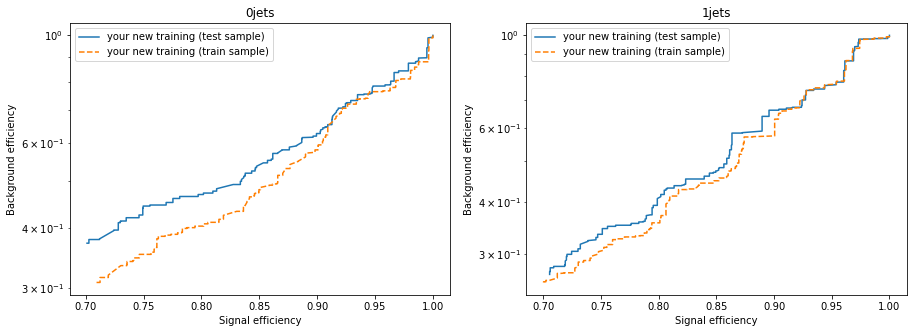

In [519]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i,group_df in df.groupby("njets30"):
    
    df_train = group_df.query('test==False')
    df_test = group_df.query("test==True")
    
    ax=axes[i%3]
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    #plot_roc_curve(df_test, "lep1pt", ax=ax)
    plot_roc_curve(df_test, "score", ax=ax, label="your new training (test sample)")
    plot_roc_curve(df_train, "score", ax=ax, color="#ff7f02", linestyle='--', label="your new training (train sample)")
    ax.set_title(category[i])
    ax.legend()

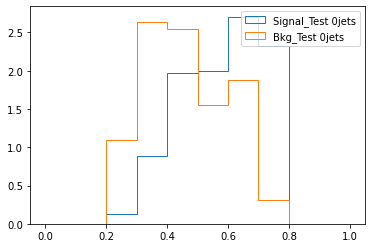

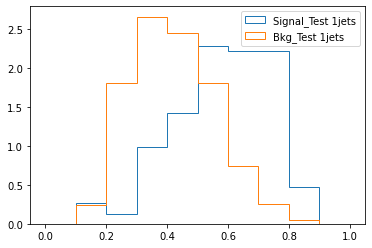

In [520]:
for i,group_df in df.groupby("njets30"):
    df_WWg_test = group_df.query('test==True & isSignal==1')
    df_bkg_test = group_df.query('test==True & isSignal!=1')
    Bins = np.linspace(0,1,10+1)
#    Bins = 20
    plt.figure()
    plt.hist(df_WWg_test['score'],bins=Bins,histtype="step",label="Signal_Test "+category[i],density = True)
    plt.hist(df_bkg_test['score'],bins=Bins,histtype="step",label="Bkg_Test "+category[i],density = True)
    plt.legend()

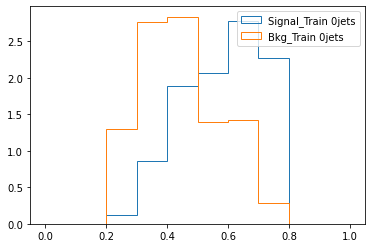

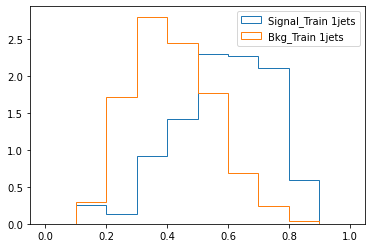

In [521]:
for i,group_df in df.groupby("njets30"):
    df_WWg_train = group_df.query('test==False & isSignal==1')
    df_bkg_train = group_df.query('test==False & isSignal!=1')
    Bins = np.linspace(0,1,10+1)
#    Bins = 10
    plt.figure()
    plt.hist(df_WWg_train['score'],bins=Bins,histtype="step",label="Signal_Train "+category[i],density = True)
    plt.hist(df_bkg_train['score'],bins=Bins,histtype="step",label="Bkg_Train "+category[i],density = True)
    plt.legend()

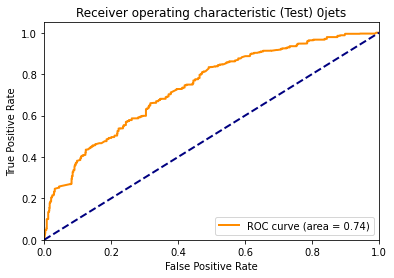

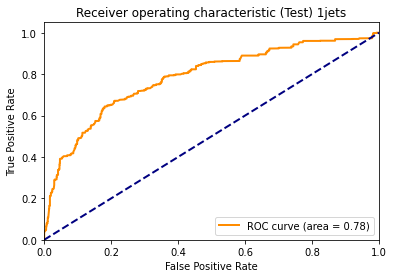

In [522]:
from sklearn.metrics import roc_curve, auc
for i,group_df in df.groupby("njets30"):
    
    df_train = group_df.query('test==False')
    df_test = group_df.query("test==True")

    fpr, tpr, _ = roc_curve(df_test['isSignal'], df_test['score'])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (Test) '+category[i])
    plt.legend(loc="lower right")

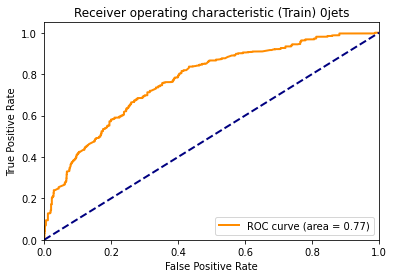

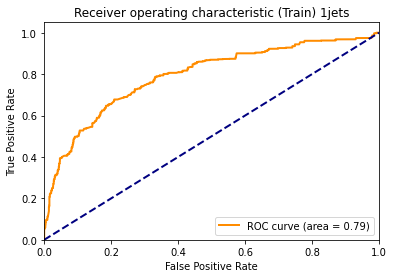

In [523]:
from sklearn.metrics import roc_curve, auc
for i,group_df in df.groupby("njets30"):
    
    df_train = group_df.query('test==False')
    df_test = group_df.query("test==True")

    fpr, tpr, _ = roc_curve(df_train['isSignal'], df_train['score'])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (Train) '+category[i])
    plt.legend(loc="lower right")

In [524]:
model1=xgb.Booster()
model1.load_model('./model_0jets.json')
model2=xgb.Booster()
model2.load_model('./model_1jets.json')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

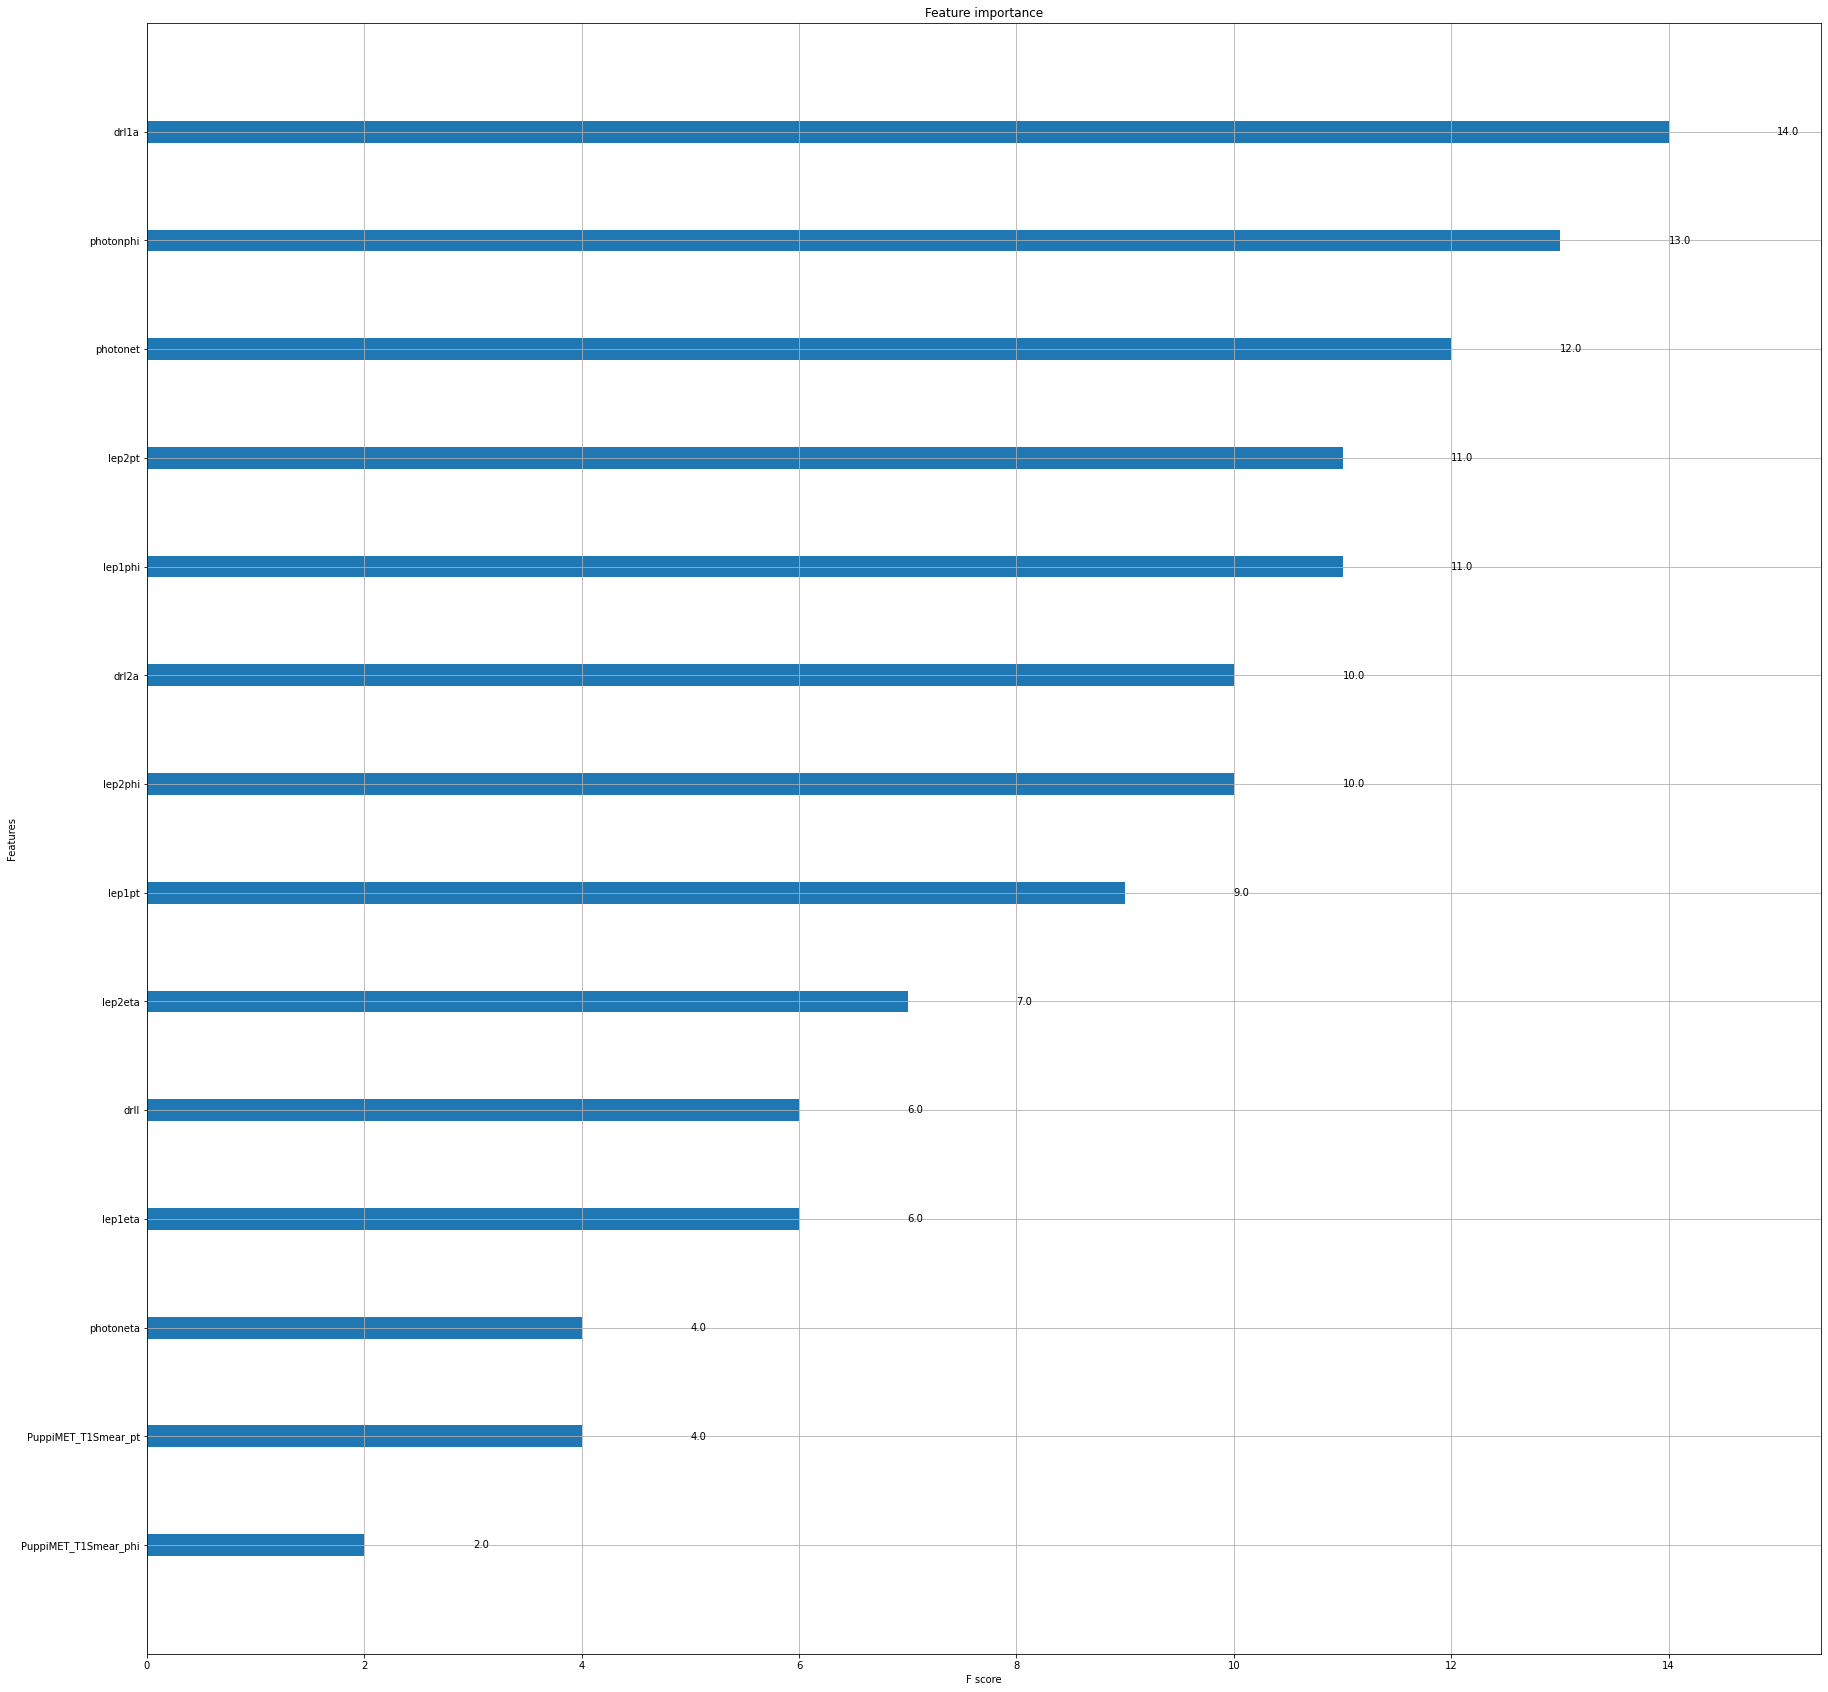

In [525]:
from xgboost import plot_importance
plt.figure(figsize = (30,30))
ax = plt.subplot(111)

plot_importance(model1,ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

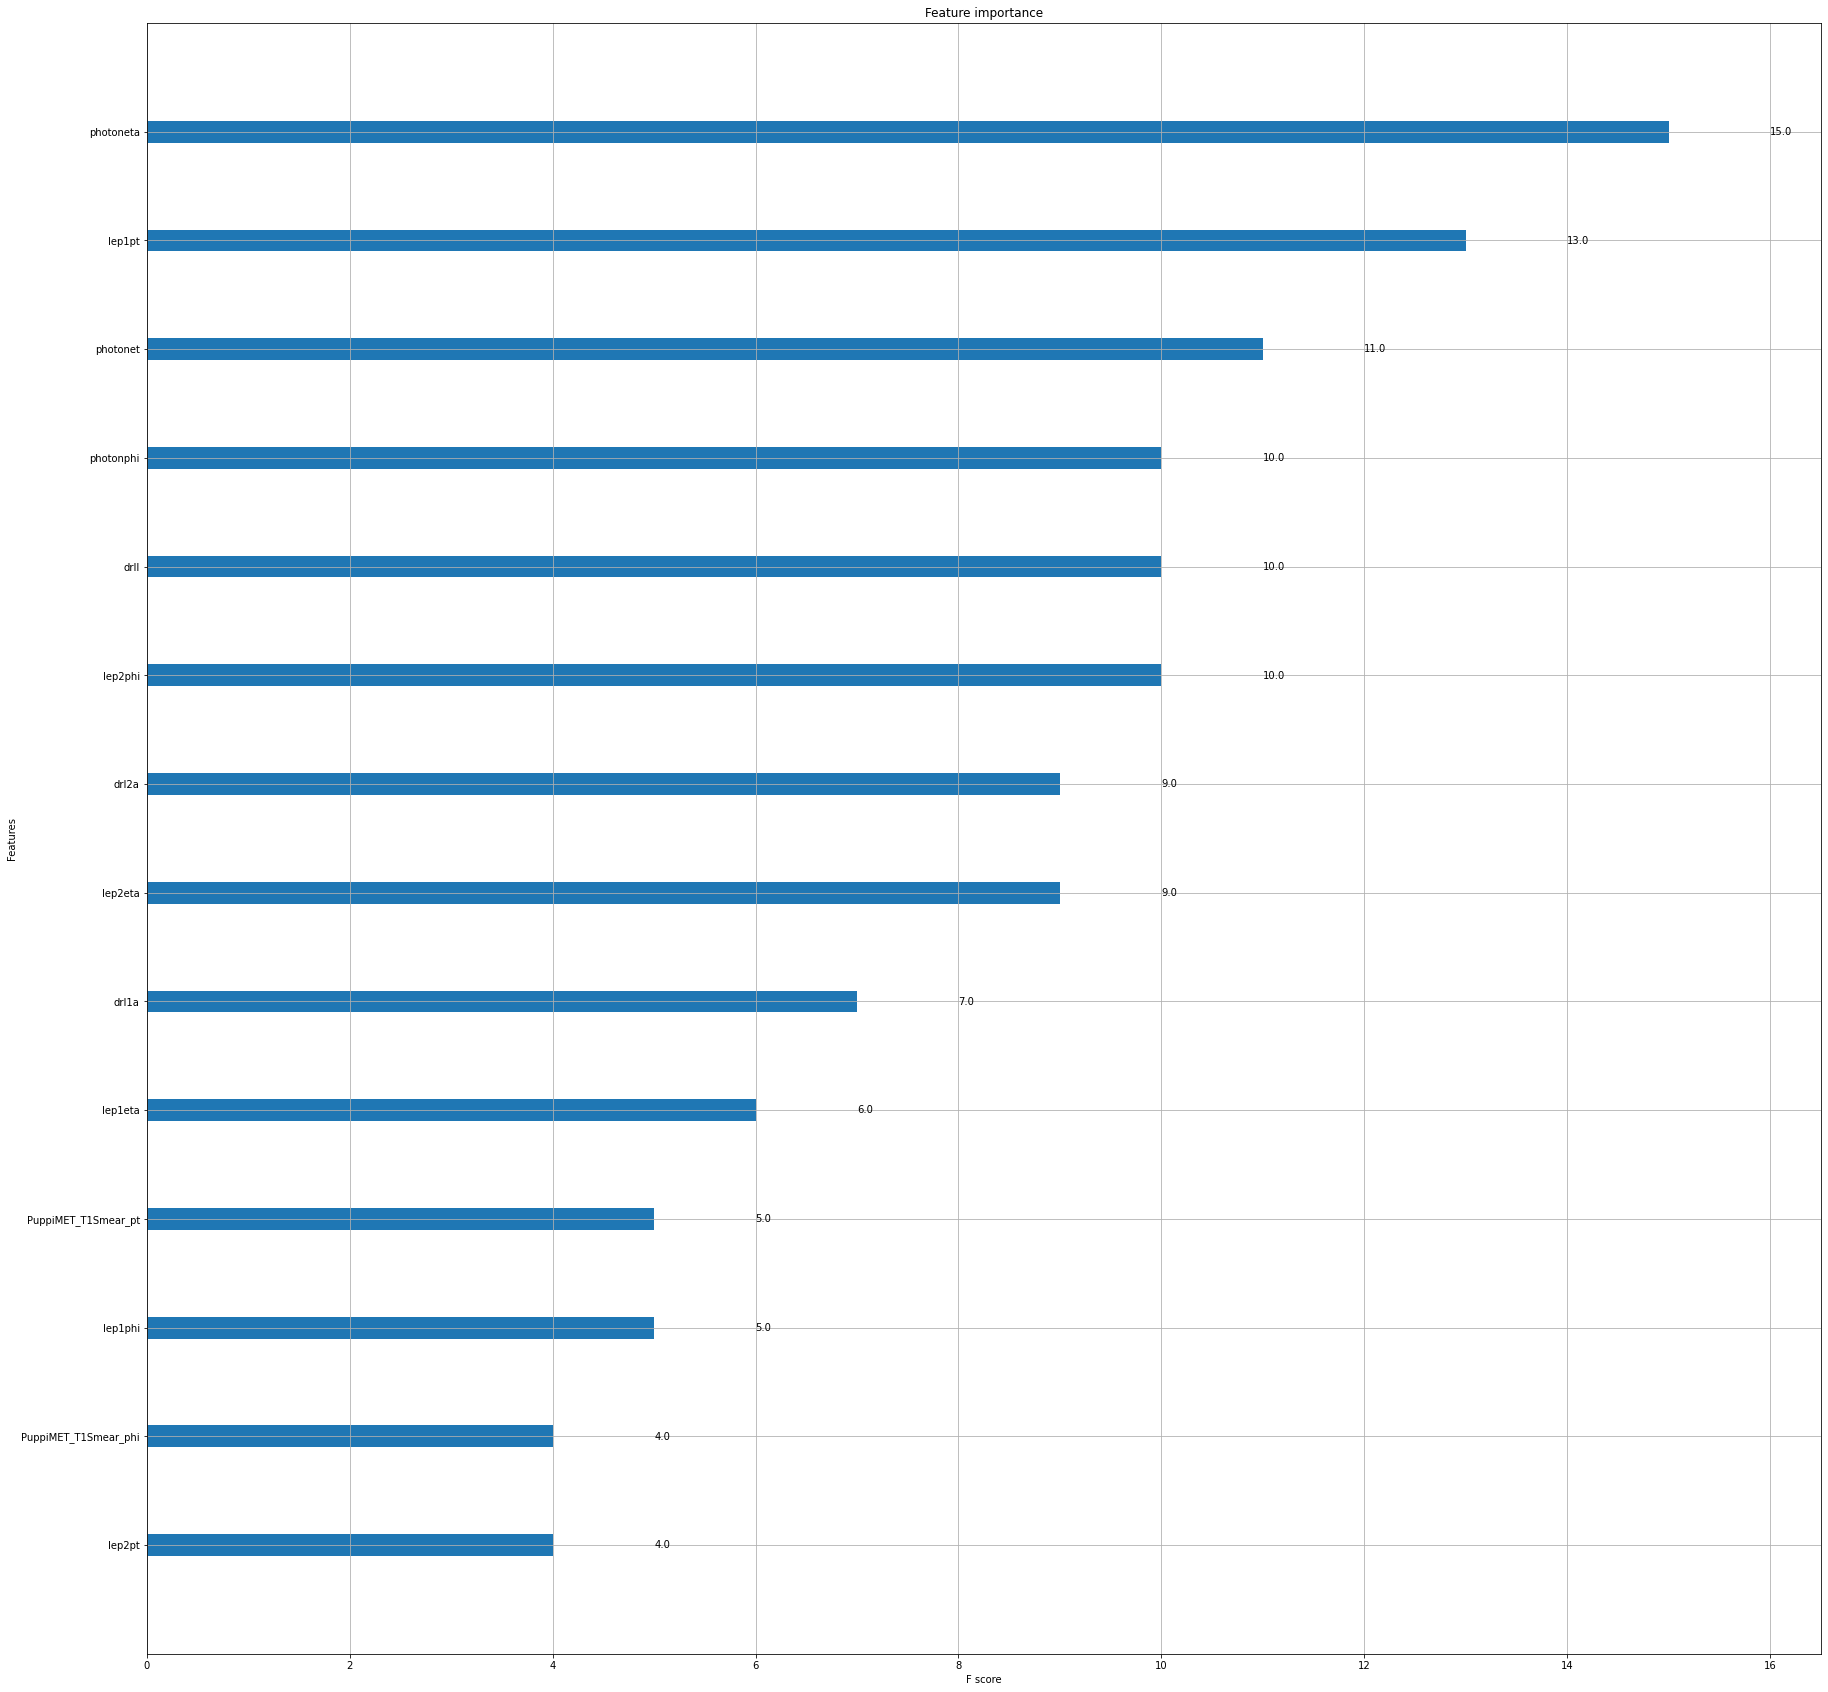

In [526]:
plt.figure(figsize = (30,30))
ax = plt.subplot(111)
plot_importance(model2,ax=ax)

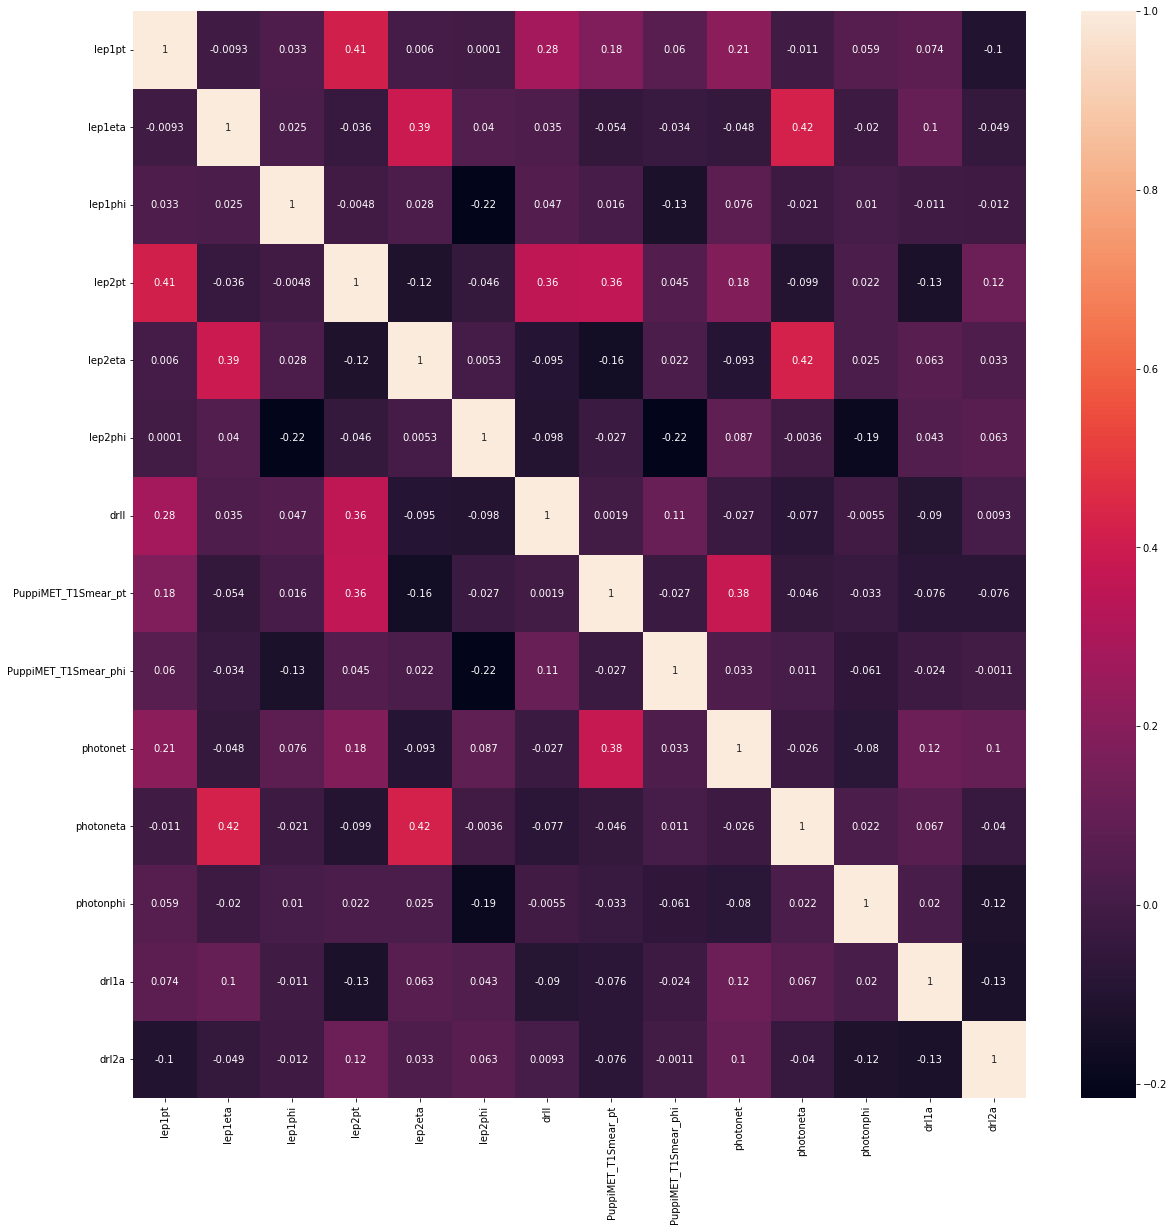

In [527]:
import seaborn as sns
plt.figure(figsize = (20,20))
corr = df_tmp[features].corr()
sns.heatmap(corr, annot = True)
#sns.heatmap(corr)
plt.show()

In [528]:
root_files18 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*18.root")
root_files17 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*17.root")
root_files16 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*16.root")

In [529]:
root_files18

['/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WGJets18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WWG_emu18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ZGJets18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_fakeL18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_plj18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_tZq18.root']

In [530]:
def get_df_year(root_files,features,lumi):
#   df = pd.concat((get_df(f) for f in tqdm(root_files)), ignore_index=True)
    ls=[]
    for f in root_files:
#        print(f)
        df_tmp = get_df(f)
        if 'plj' not in f and 'fake' not in f:
            print(f)
            df_tmp['actualWeight']=df_tmp['actualWeight']*lumi
        ls.append(df_tmp)
    df=pd.concat(ls,ignore_index=True)
    for i,group_df in df.groupby("njets30"):
        model=xgb.Booster()
        model.load_model('./model_'+str(i)+'jets.json')
        dmatrix = xgb.DMatrix(group_df[features], label=np.copy(group_df['isSignal']))
        df.loc[group_df.index, "score"] = model.predict(dmatrix)
    return df       

In [531]:
df18=get_df_year(root_files18,features,59.7)

/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WWG_emu18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ZGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_tZq18.root


In [532]:
import ROOT
def get_hist(df):
    hist=ROOT.TH1D("h1","",10,0,1)
    for i in range(0,df.shape[0]):
        hist.Fill(df['score'].iloc[i],df['actualWeight'].iloc[i])
    return hist        

In [533]:
bkg=df18.query('isSignal!=1 ')
sig=df18.query('isSignal==1 ')

In [534]:
hist_sig=get_hist(sig)
hist_bkg=get_hist(bkg)

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


In [535]:
c1=ROOT.TCanvas("c1","",900,600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


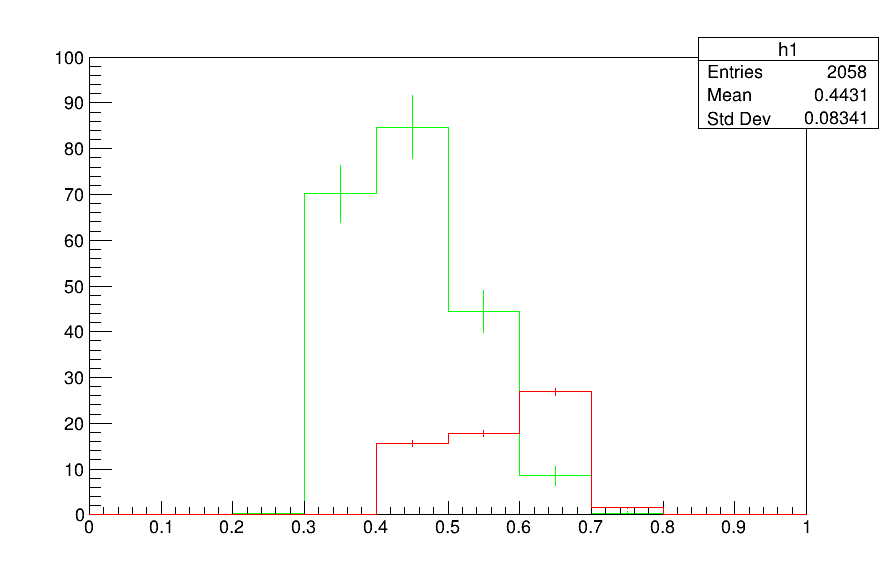

In [493]:
hist_bkg.SetLineColor(3)
hist_bkg.Draw("hist E")
hist_bkg.GetYaxis().SetRangeUser(0,100)
#gStyle.SetOptStat(0)
hist_sig.SetLineColor(2)
hist_sig.Draw('hist E same')
c1.Draw()
c1.Update()

(array([  0.        ,   0.        ,   0.17801517,  70.12223816,
        100.39739227,  62.20161438,  35.3770752 ,   1.92037964,
          0.        ,   0.        ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [<matplotlib.patches.Polygon at 0x7fbef9048e20>])

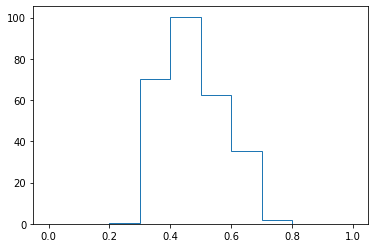

In [494]:
Bins = np.linspace(-0,1,10+1)
#Bins = 10
plt.figure()
plt.hist(df18['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=df18['actualWeight'])

In [495]:
data_files18 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal*18.root")
data_files17 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal*17.root")

In [496]:
data_files18

['/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_Muon18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_MuonEG18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_Ele18.root']

In [497]:
data18=get_df_year(data_files18,features,1)

/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_Muon18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_MuonEG18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/data/optimal_emua_Ele18.root


(array([ 0.,  0.,  1., 85., 95., 60., 30.,  1.,  0.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [<matplotlib.patches.Polygon at 0x7fc08c0e7be0>])

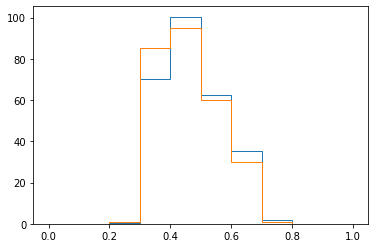

In [498]:
Bins = np.linspace(0,1,10+1)
#Bins = 10
plt.figure()
plt.hist(df18['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=df18['actualWeight'])
#plt.hist(bkg['score'],bins=Bins,histtype="step",label="Signal_Test",
#         density = False,weights=bkg['actualWeight'])
#plt.hist(sig['score'],bins=Bins,histtype="step",label="Signal_Test",
#         density = False,weights=sig['actualWeight'])
plt.hist(data18['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=data18['actualWeight'])

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.32176280e-03,
         1.56660423e+01,  1.77961559e+01,  2.68625412e+01,  1.52690125e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [<matplotlib.patches.Polygon at 0x7fc08c2dfa00>])

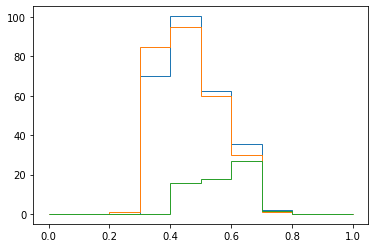

In [499]:
Bins = np.linspace(0,1,10+1)
#Bins = 10
plt.figure()
plt.hist(df18['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=df18['actualWeight'])
#plt.hist(bkg['score'],bins=Bins,histtype="step",label="Signal_Test",
#         density = False,weights=bkg['actualWeight'])
plt.hist(data18['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=data18['actualWeight'])
plt.hist(sig['score'],bins=Bins,histtype="step",label="Signal_Test",
         density = False,weights=sig['actualWeight'])